# Analysis of CMIP6, ERA5, and CloudSat


# Table of Contents
<ul>
<li><a href="#introduction">1. Introduction</a></li>
<li><a href="#data_wrangling">2. Data Wrangling</a></li>
<li><a href="#exploratory">3. Exploratory Data Analysis</a></li>
<li><a href="#conclusion">4. Conclusion</a></li>
<li><a href="#references">5. References</a></li>
</ul>

# 1. Introduction <a id='introduction'></a>


**Questions**
* How is the cloud phase and snowfall 


> **_NOTE:_** .

# 2. Data Wrangling <a id='data_wrangling'></a>


## Organize my data

- Define a prefix for my project (you may need to adjust it for your own usage on your infrastructure).
    - input folder where all the data used as input to my Jupyter Notebook is stored (and eventually shared)
    - output folder where all the results to keep are stored
    - tool folder where all the tools

The ERA5 0.25deg data is located in the folder `\scratch\franzihe\`, CloudSat at ...



In [1]:
lwp_threshold = 3


In [2]:
import os
import pathlib
import sys
import socket
hostname = socket.gethostname()

abs_path = str(pathlib.Path(hostname).parent.absolute())
WORKDIR = abs_path[:- (len(abs_path.split('/')[-2] + abs_path.split('/')[-1])+1)]


if "mimi" in hostname:
    print(hostname)
    DATA_DIR = "/mn/vann/franzihe/"
    # FIG_DIR = "/uio/kant/geo-geofag-u1/franzihe/Documents/Figures/ERA5/"
    FIG_DIR = f"/uio/kant/geo-geofag-u1/franzihe/Documents/Python/globalsnow/CloudSat_ERA5_CMIP6_analysis/Figures/CS_ERA5_CMIP6_hourly_{lwp_threshold}/"
elif "glefsekaldt" in hostname: 
    DATA_DIR = "/home/franzihe/Data/"
    FIG_DIR = "/home/franzihe/Documents/Figures/ERA5/"

INPUT_DATA_DIR = os.path.join(DATA_DIR, 'input')
OUTPUT_DATA_DIR = os.path.join(DATA_DIR, 'output')
UTILS_DIR = os.path.join(WORKDIR, 'utils')
FIG_DIR_mci = os.path.join(FIG_DIR, 'McIlhattan/')

sys.path.append(UTILS_DIR)
# make figure directory
try:
    os.mkdir(FIG_DIR)
except OSError:
    pass

try:
    os.mkdir(FIG_DIR_mci)
except OSError:
    pass

mimi.uio.no


## Import python packages
- `Python` environment requirements: file [requirements_globalsnow.txt](../../requirements_globalsnow.txt) 
- load `python` packages from [imports.py](../../utils/imports.py)
- load `functions` from [functions.py](../../utils/functions.py)


In [3]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
from imports import(xr, ccrs, cy, plt, glob, cm, fct, np, pd, add_cyclic_point)
# from matplotlib.lines import Line2D
# from matplotlib.patches import Patch
# from sklearn.metrics import r2_score


xr.set_options(display_style='html')

In [4]:
# reload imports
%load_ext autoreload
%autoreload 2

## Open variables
Get the data requried for the analysis. 



In [5]:
dat_in = os.path.join(OUTPUT_DATA_DIR, 'CS_ERA5_CMIP6')
dat_in
# make output data directory
# try:
#     os.mkdir(dat_out)
# except OSError:
#     pass

'/mn/vann/franzihe/output/CS_ERA5_CMIP6'

In [6]:
# variable_id = ['tas', 'prsn', 'pr', 'lwp', 'clivi', 'areacella']

In [7]:
# Define list of models
list_models = [#'cloudsat_250',
               'cloudsat_500',
               # 'era_30',
               # 'era_250',
               'era_500',
               # 'cmip_250',
               'cmip_500',
               # 'MIROC6', 
               # 'CanESM5', 
               # 'AWI-ESM-1-1-LR', 
               # 'MPI-ESM1-2-LR', 
               # 'UKESM1-0-LL', 
               # 'HadGEM3-GC31-LL',
               # 'CNRM-CM6-1',
               # 'CNRM-ESM2-1',
               # 'IPSL-CM6A-LR',
               # 'IPSL-CM5A2-INCA'
            ]



In [8]:
# Create empty dictionaries to store the Xarray datasets for different variables:
variables = ['orig', '2t', 'lcc', 'lcc_2t', 'lcc_sf', 'lcc_2t_days', 'lcc_2t_sf', ]
ds = {var: {} for var in variables}
ds_mci = {var: {} for var in variables}
ds_hourly = {var: {} for var in variables}

In [9]:
for model in list_models:
    
    for var in variables:
        if model == 'cloudsat_250' or model == 'cloudsat_500' or var == 'orig' or var == '2t':
            file_pattern = f'{dat_in}/{var}/{model}_{var}*.nc'
        else:
            file_pattern = f'{dat_in}/{lwp_threshold}_{var}/{model}_{lwp_threshold}_{var}*.nc'
        # print(file_pattern)
        files = sorted(glob(file_pattern))
        # print(files)
        for file in files:
            _ds = xr.open_mfdataset(file)
            # [var][model]
            ds[var][model] = xr.Dataset()
            # ds_mci[var][model] = xr.Dataset()
            # make the data cyclic going from -180 to 180
            for var_id in _ds.keys():
                data = _ds[var_id]
                
                if 'lon' in _ds[var_id].dims and (data['lon'][0] != data['lon'][-1]*(-1)):
                    lon = _ds.coords['lon']
                    lon_idx = data.dims.index('lon')
                    wrap_data, wrap_lon = add_cyclic_point(data, coord=lon, axis=lon_idx)
                    
                    if len(wrap_data.shape) == 2:
                        ds[var][model][var_id] = xr.DataArray(data = wrap_data, coords=dict(lat=data['lat'],
                                                                                            lon=np.append(data['lon'].values, data['lon'][0].values*(-1))))
                    
                    if len(wrap_data.shape) == 3:
                        if 'time' in data.dims:
                            ds[var][model][var_id] = xr.DataArray(data = wrap_data, coords=dict(time=data['time'],
                                                                                                lat=data['lat'],
                                                                                                lon=np.append(data['lon'].values, data['lon'][0].values*(-1))))
                        elif 'model' in data.dims:
                            ds[var][model][var_id] = xr.DataArray(data = wrap_data, coords=dict(lat=data['lat'],
                                                                                                lon=np.append(data['lon'].values, data['lon'][0].values*(-1)),
                                                                                                model=data['model']), 
                                                                  )
                    if len(wrap_data.shape) == 4:
                        ds[var][model][var_id] = xr.DataArray(data = wrap_data, coords=dict(time=data['time'],
                                                                                            lat=data['lat'],
                                                                                            lon=np.append(data['lon'].values, data['lon'][0].values*(-1)),
                                                                                            model=data['model']))
                        
                else:
                    ds[var][model][var_id] = data
                    
                ds[var][model][var_id].attrs = data.attrs
                
            # ds_mci[var][model] = xr.concat([ds[var][model].sel(lat=slice(-90,-66.91)),
            #                                 ds[var][model].sel(lat=slice(66.91,90))], dim ='lat')
            # ds_mci[var][model] = ds[var][model].where(np.logical_and((ds[var][model].lat<=66.91),(ds[var][model].lat>=66.91)), other=np.nan )
            
# Access the datasets using  ds[var][model]
# For example:
# lcc_2t_days_dataset = ds['lcc_2t_days']['era_30']




In [10]:
for model in list_models:
# for model in list_models[1:2]:

    
    for var in variables:
        if model == 'cloudsat_250' or model == 'cloudsat_500':
            file_pattern = f'{dat_in}/{var}/{model}_{var}*.nc'
        elif model == 'era_30' or model == 'era_250' or model == 'era_500':
            if var == 'orig' or var == '2t':
                file_pattern = f'{dat_in}_hourly/{var}/{model}_{var}*.nc'
            else:
                file_pattern = f'{dat_in}_hourly/{lwp_threshold}_{var}/{model}_{lwp_threshold}_{var}*.nc'
        else:
            if var == 'orig' or var == '2t':
                file_pattern = f'{dat_in}/{var}/{model}_{var}*.nc'
            else:
                file_pattern = f'{dat_in}/{lwp_threshold}_{var}/{model}_{lwp_threshold}_{var}*.nc'
                
                
        files = sorted(glob(file_pattern))
        # print(files)
        for file in files:
            _ds_hourly = xr.open_mfdataset(file)
            # [var][model]
            ds_hourly[var][model] = xr.Dataset()
            # ds_hourly_mci[var][model] = xr.Dataset()
            # make the data cyclic going from -180 to 180
            for var_id in _ds_hourly.keys():
                data = _ds_hourly[var_id]
                
                if 'lon' in _ds_hourly[var_id].dims and (data['lon'][0] != data['lon'][-1]*(-1)):
                    lon = _ds_hourly.coords['lon']
                    lon_idx = data.dims.index('lon')
                    wrap_data, wrap_lon = add_cyclic_point(data, coord=lon, axis=lon_idx)
                    
                    if len(wrap_data.shape) == 2:
                        ds_hourly[var][model][var_id] = xr.DataArray(data = wrap_data, coords=dict(lat=data['lat'],
                                                                                            lon=np.append(data['lon'].values, data['lon'][0].values*(-1))))
                    
                    if len(wrap_data.shape) == 3:
                        if 'time' in data.dims:
                            ds_hourly[var][model][var_id] = xr.DataArray(data = wrap_data, coords=dict(time=data['time'],
                                                                                                lat=data['lat'],
                                                                                                lon=np.append(data['lon'].values, data['lon'][0].values*(-1))))
                        elif 'model' in data.dims:
                            ds_hourly[var][model][var_id] = xr.DataArray(data = wrap_data, coords=dict(lat=data['lat'],
                                                                                                lon=np.append(data['lon'].values, data['lon'][0].values*(-1)),
                                                                                                model=data['model']), 
                                                                  )
                    if len(wrap_data.shape) == 4:
                        ds_hourly[var][model][var_id] = xr.DataArray(data = wrap_data, coords=dict(time=data['time'],
                                                                                            lat=data['lat'],
                                                                                            lon=np.append(data['lon'].values, data['lon'][0].values*(-1)),
                                                                                            model=data['model']))
                        
                else:
                    ds_hourly[var][model][var_id] = data
                    
                ds_hourly[var][model][var_id].attrs = data.attrs
                
            # ds_hourly_mci[var][model] = xr.concat([ds_hourly[var][model].sel(lat=slice(-90,-66.91)),
            #                                 ds_hourly[var][model].sel(lat=slice(66.91,90))], dim ='lat')
            # ds_hourly_mci[var][model] = ds_hourly[var][model].where(np.logical_and((ds_hourly[var][model].lat<=66.91),(ds_hourly[var][model].lat>=66.91)), other=np.nan )
            
# Access the datasets using  ds_hourly[var][model]
# For example:
# lcc_2t_days_dataset = ds_hourly['lcc_2t_days']['era_30']




In [11]:
# for var in ds.keys():
#     for model in ['cloudsat_250', 'cloudsat_500', 'cmip_250', 'cmip_500']:
#         # ds_hourly[var][model] = xr.Dataset()
#         try: 
#             ds_hourly[var][model] = ds[var][model]
#         except KeyError:
#             # print(var, model)
#             continue

In [12]:
dict_label = {
     # 'lcc_wo_snow': {'cb_label':'FsLCC (%)', 'levels':np.arange(0,110,10), 'vmin': 0, 'vmax':100, 'diff_levels':np.arange(-30,35,5), 'diff_vmin':-30, 'diff_vmax':30},
#      'lcc_w_snow':  {'cb_label':'FoS in sLCCs (%)', 'levels':np.arange(0,110,10), 'vmin': 0, 'vmax':100, 'diff_levels':np.arange(-60,65,5), 'diff_vmin':-60, 'diff_vmax':60},
#      'sf_eff':      {'cb_label':'SE in sLCCs (h$^{-1}$)', 'levels':np.arange(0,5.5,.5), 'vmin':0, 'vmax':5, 'diff_levels':np.arange(-1.2,1.4,.2), 'diff_vmin':-1.2, 'diff_vmax':1.2}#'Relative snowfall efficiency (h$^{-1}$)'
     
     'FLCC' : {'cb_label':'FLCC (%)',             'levels':np.arange(0,105.,5.), 'vmin':0, 'vmax': 100.,   'diff_levels':np.arange(-100,110,10),   'diff_vmin':-100, 'diff_vmax':100},
     'FsLCC': {'cb_label':'FsLCC (%)',            'levels':np.arange(0,105.,5.), 'vmin':0, 'vmax': 100,   'diff_levels':np.arange(-100,110,10),   'diff_vmin':-100, 'diff_vmax':100},
     # # 'FoP'  : {'cb_label':'FoP in LCCs (%)',      'levels':np.arange(0,105.,5.), 'vmin':0, 'vmax': 100,   'diff_levels':np.arange(-100,110,10),   'diff_vmin':-100, 'diff_vmax':100},
     # 'FoS'  : {'cb_label':'FoS in sLCCs (%)',     'levels':np.arange(0,105.,5.), 'vmin':0, 'vmax': 100,   'diff_levels':np.arange(-100,110,10),   'diff_vmin':-100, 'diff_vmax':100},
     # 'sf_eff': {'cb_label':'SE in sLCCs (h$^{-1}$)','levels':np.arange(0,5.5,.5), 'vmin':0, 'vmax': 5,   'diff_levels':np.arange(-1.2,1.4,.2),   'diff_vmin':-1.2, 'diff_vmax':1.2},
     # # 'pr_eff': {'cb_label':'PE in sLCCs (h$^{-1}$)', 'levels':np.arange(0,550.,50.), 'vmin':0, 'vmax':500,   'diff_levels':np.arange(-120,140,20),   'diff_vmin':-120, 'diff_vmax':120},
     'FLCC-FsLCC': {'cb_label':'FLCC (%), FsLCC (%)',  'levels':np.arange(0,105.,5.), 'vmin':0, 'vmax': 100,   'diff_levels':np.arange(-100,110,10),   'diff_vmin':-100, 'diff_vmax':100}}


In [13]:
for var in ds.keys():
    print(var, ds[var].keys())

orig dict_keys(['cloudsat_500', 'era_500', 'cmip_500'])
2t dict_keys(['cloudsat_500', 'era_500', 'cmip_500'])
lcc dict_keys(['era_500', 'cmip_500'])
lcc_2t dict_keys(['cloudsat_500', 'era_500', 'cmip_500'])
lcc_sf dict_keys(['cloudsat_500', 'era_500', 'cmip_500'])
lcc_2t_days dict_keys(['cloudsat_500', 'era_500', 'cmip_500'])
lcc_2t_sf dict_keys(['cloudsat_500', 'era_500', 'cmip_500'])


In [23]:
ratios = fct.get_ratios_dict(list_models, ds,seasons='normal')
ratios_hourly = fct.get_ratios_dict(list_models, ds_hourly,seasons='normal')

# ratios_mci = fct.get_ratios_dict(list_models, ds_mci,seasons=None)


In [24]:
for variables in ratios['cloudsat_500'].variables:
    for var_name in dict_label.keys():
        if var_name in variables:
            ratios = fct.get_only_valid_values(ratios, '500', variables)
            ratios_hourly = fct.get_only_valid_values(ratios_hourly, '500', variables)
    

In [25]:
# # Calculate weighted averages

for model in ratios.keys():
    weights = ds['orig'][model]['areacella']
    for vars in ratios[model].keys():
        ratios[model][vars+'_mean'], ratios[model][vars+'_std'], ratios[model][vars+'_stats'] = fct.weighted_average(ratios[model][vars], weights)
        # ratios_mci[model][vars+'_mean'], ratios_mci[model][vars+'_std'], ratios_mci[model][vars+'_stats'] = fct.weighted_average(ratios_mci[model][vars], weights)
        


In [26]:
for model in ratios_hourly.keys():
    weights_hourly = ds_hourly['orig'][model]['areacella']
    for vars in ratios_hourly[model].keys():
        ratios_hourly[model][vars+'_mean'], ratios_hourly[model][vars+'_std'], ratios_hourly[model][vars+'_stats'] = fct.weighted_average(ratios_hourly[model][vars], weights_hourly)
     

In [28]:
ratios_hourly['500'] = xr.concat([ratios_hourly['cloudsat_500'].assign_coords(coords={'model':'CloudSat'}),
                                  ratios_hourly['era_500'].assign_coords(coords={'model':'ERA5'}),
                                  ratios_hourly['cmip_500']], dim=("model"))

In [29]:
file_dir_hourly = os.path.join(OUTPUT_DATA_DIR, 'CS_ERA5_CMIP6_hourly/ratios_500/')
try:
    os.mkdir(file_dir_hourly)
except OSError:
    pass

In [33]:
for var_name in dict_label.keys():
    file_name = f'{var_name}_LWP{lwp_threshold}_2007_2010.nc'
    (ratios_hourly['500'][[f'{var_name}_season', f'{var_name}_season_cs_mean',
                           f'{var_name}_month_mean', f'{var_name}_year_mean', f'{var_name}_month_cs_mean', f'{var_name}_year_cs_mean',
                           f'{var_name}_month_years_mean', f'{var_name}_year_years_mean', f'{var_name}_season_mean',
                           ]]).to_netcdf(path=os.path.join(file_dir_hourly, file_name), format="NETCDF4")
    

In [46]:
ds_dict = ratios
ds_dict_hourly = ratios_hourly
fig_dir = FIG_DIR
var_name = 'FLCC'
# var_name = 'FsLCC'

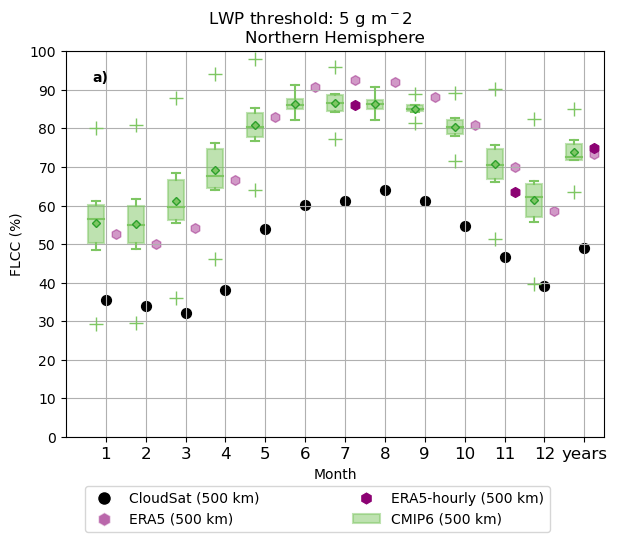

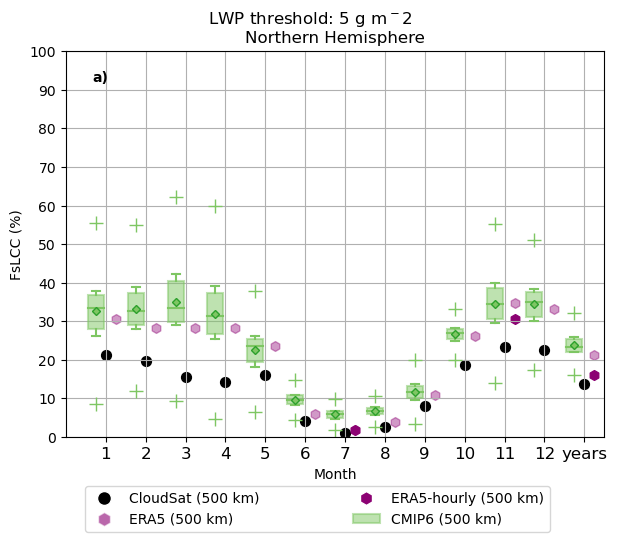

In [47]:
for var_name in ['FLCC', 'FsLCC']:
    colors = cm.hawaii(range(0, 256, int(256 / 3) + 1))
    f, axsm = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=[6, 5])
    f.suptitle(f'LWP threshold: {lwp_threshold} g m$^{-2}$', y=1.005)
    # ax = axsm.flat
    bp= [[],]
    cmip_key = 'cmip_500'

    i = 0
    hemisphere = 'NH'

    axsm.grid(True)
    cs_data = xr.concat([ds_dict['cloudsat_500'][var_name + '_month_mean'].sel(hemisphere=hemisphere),
                        ds_dict['cloudsat_500'][var_name + '_year_mean'].sel(hemisphere=hemisphere).assign_coords(coords={'month':13})], dim='month')
    axsm.scatter(x=np.arange(1,14), y=cs_data, color='k', marker='o',s=50)

    era_data = xr.concat([ds_dict['era_500'][var_name + '_month_cs_mean'].sel(hemisphere=hemisphere,),
                        ds_dict['era_500'][var_name + '_year_cs_mean'].sel(hemisphere=hemisphere,).assign_coords(coords={'month':13})], dim='month')
    era_data_hourly = xr.concat([ds_dict_hourly['era_500'][var_name + '_month_cs_mean'].sel(hemisphere=hemisphere,),
                                ds_dict_hourly['era_500'][var_name + '_year_cs_mean'].sel(hemisphere=hemisphere,).assign_coords(coords={'month':13})], dim='month')
    axsm.scatter(x=np.arange(1.25,14.25), y=era_data, color=colors[0], marker="h", s=50, alpha = 0.4)
    axsm.scatter(x=[.25+7, .25+11, 0.25+13], y=era_data_hourly, color=colors[0], marker="h", s=50)


    cmip_data = xr.concat([ds_dict[cmip_key][var_name + '_month_cs_mean'],
                        ds_dict[cmip_key][var_name + '_year_cs_mean'].assign_coords(coords={'month':'years'})], dim='month')

    quantiles = cmip_data.quantile([0.25, 0.5, 0.75], dim=('model'), skipna=True, keep_attrs=False)
    iqr = quantiles.sel(quantile=0.75) - quantiles.sel(quantile=0.25)
    max_val = (quantiles.sel(quantile=0.75) + 1.5 * iqr).assign_coords({'quantile': 'min'})
    min_val = (quantiles.sel(quantile=0.25) - 1.5 * iqr).assign_coords({'quantile': 'max'})
    # means = ds_dict[cmip_key][var_name + '_month_mean'].mean(dim='model', skipna=True).assign_coords({'quantile': 'mean'})
    means = cmip_data.mean(dim='model', skipna=True).assign_coords({'quantile':'mean'})
    stats = xr.concat([max_val, quantiles, min_val, means], dim='quantile')

    positions = np.arange(0 + 0.75, 0 + 13.75, 1)
    boxplot_data = stats.sel(hemisphere=hemisphere,).transpose('quantile', 'month')
    j=0
    bp[j] = axsm.boxplot(boxplot_data,  positions=positions, widths=0.4, 
                                boxprops=dict(color=colors[2], lw=1.5),
                                medianprops=dict(color=colors[2], lw=1.5),
                                whiskerprops=dict(color=colors[2], lw=1.5),
                                capprops=dict(color=colors[2], lw=1.5),
                                flierprops=dict(marker='+',markeredgecolor=colors[2], markersize=10),
                                showmeans=True, meanprops=dict(marker='D',markerfacecolor=colors[2], markersize=4),
                                patch_artist=True,)

    for patch in bp[j]['boxes']:
        patch.set(facecolor=colors[2], alpha=0.5)

    axsm.set_title('Northern Hemisphere' if hemisphere == 'NH' else 'Southern Hemisphere')   
    axsm.text(0.05, 0.95, f'{fct.fig_label[i]}', fontweight='bold', horizontalalignment='left', verticalalignment='top', transform=axsm.transAxes)
    axsm.set_xticks(np.arange(1,14)) 
    axsm.set_xlim([0, 13.5])

    axsm.set_xticklabels(np.append(np.arange(1,13), 'years'), fontsize=12)
    axsm.set_xlabel('Month')

    axsm.set_ylim([dict_label[var_name]['vmin'],dict_label[var_name]['vmax']])
    axsm.set_yticks(np.arange(0,110,10))

    axsm.set_ylabel(dict_label[var_name]['cb_label'] if i==0 else '')


    s = f.subplotpars
    bb = [s.left, s.top - 0.92, (s.right - s.left), 0.05]

    axsm.legend([
                fct.Line2D([0], [0], marker='o', color='w', label='CloudSat (500km)', markersize=10, markerfacecolor='k'),
                fct.Line2D([0], [0], marker='h', color='w', label='ERA5 (500 km)',markersize=10, markerfacecolor=colors[0], alpha=0.6 ),
                fct.Line2D([0], [0], marker='h', color='w', label='ERA5-hourly ', markersize=10, markerfacecolor=colors[0]),
                bp[0]["boxes"][0],
            ],
            ['CloudSat (500 km)',
            'ERA5 (500 km)', 
            'ERA5-hourly (500 km)', 
            'CMIP6 (500 km)'],
            bbox_to_anchor=bb,loc=8,ncol=2,mode='expand',borderaxespad=0,fancybox=True,bbox_transform=f.transFigure,
        )

    plt.tight_layout(pad=0., w_pad=0., h_pad=0.)  ;
    figname = f'{var_name}_monthly_model_variation_2007_2010.png'
    plt.savefig(fig_dir + figname, format='png', bbox_inches='tight', transparent=True) 

In [48]:
lat_extent = 45

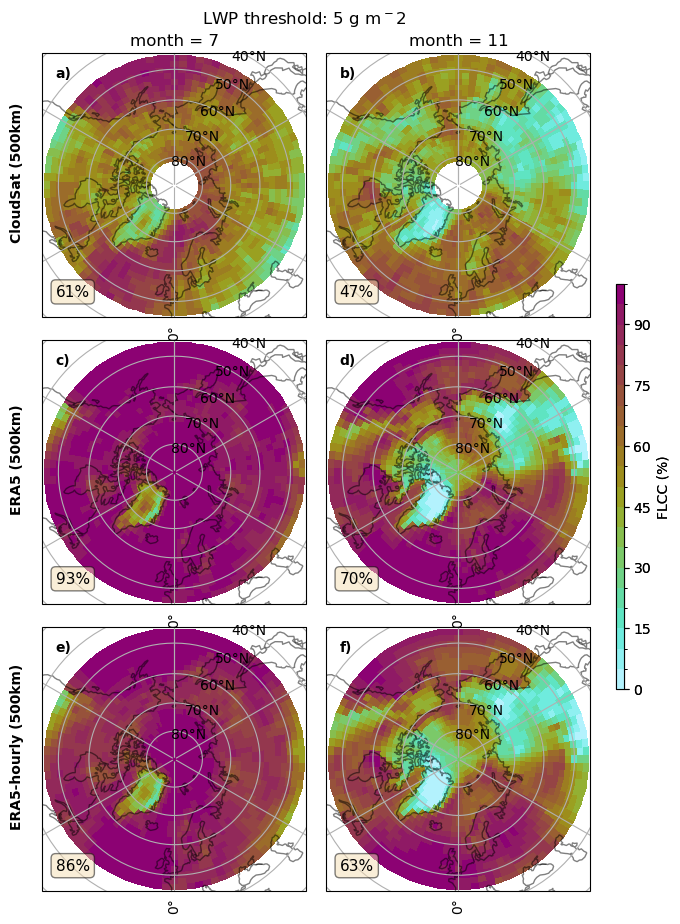

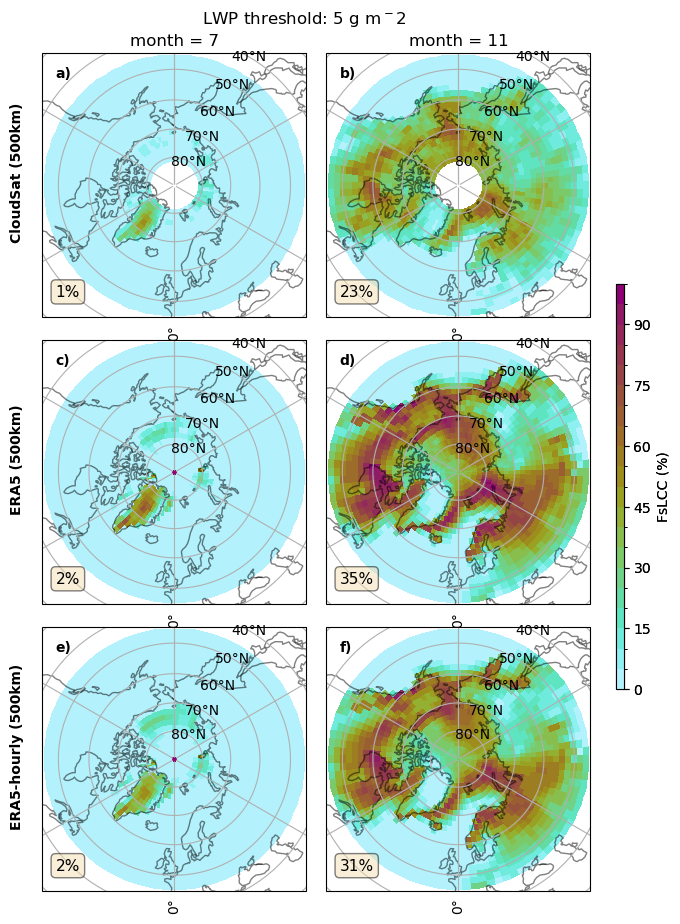

In [49]:
for var_name in ['FLCC', 'FsLCC']:
    val1= ratios['cloudsat_500'][var_name + '_month']
    val1_mean= ratios['cloudsat_500'][var_name + '_month_mean']

#     val2= ratios['era_500'][var_name + '_month_cs']
    val2= ratios['era_500'][var_name + '_month']
    val2_mean= ratios['era_500'][var_name + '' + '_month_cs_mean']

    val3= ratios_hourly['era_500'][var_name + '_month']
    val3_mean = ratios_hourly['era_500'][var_name + '' +'_month_cs_mean']

    val1= val1.where(val1>=0., other=np.nan)
    val2= val2.where(val2>=0., other=np.nan)




    if 'model' in val3.coords:
        val3 = val3.mean('model', skipna=True, keep_attrs=False)
        val3_mean = val3_mean.mean('model', skipna=True, keep_attrs=False)    
    val3= val3.where(val3>=0., other=np.nan)


    projection = fct.create_projection(hemisphere)
    density = 4
    f, axsm = plt.subplots(nrows=3, 
                                ncols=2, 
                                subplot_kw={'projection': projection}, 
                                figsize=[6, 9], sharex=True, sharey=True)
    f.suptitle(f'LWP threshold: {lwp_threshold} g m$^{-2}$', y=1.005)

    model_labels = ['CloudSat (500km)', 'ERA5 (500km)', 'ERA5-hourly (500km)']

    for ax, row in zip(axsm[:,0], model_labels):
            ax.text(-0.07, 0.55, row, 
                    va='bottom', 
                    ha='center', 
                    rotation='vertical', 
                    rotation_mode='anchor', 
                    transform=ax.transAxes, 
                    fontweight='bold')
    for ax, k in zip(axsm.flatten(), range(len(fct.fig_label))):
            fct.setup_axes(ax, hemisphere, lat_extent)
            ax.text(0.05, 0.95, 
                    f'{fct.fig_label[k]}', 
                    fontweight='bold', 
                    horizontalalignment='left', 
                    verticalalignment='top', 
                    transform=ax.transAxes)
            
    list1 = [val1, val2, val3]
    list_glob = [val1_mean, val2_mean, val3_mean]

    for i, (value,hemi_glob) in enumerate(zip(list1,list_glob)):
            if i == 0:
                cmap = cm.hawaii_r 
                levels = dict_label[var_name]['levels']
                
            norm = fct.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
            sub_title = ""
            
            for ax, month in zip(axsm.flatten()[i * 2: (i + 1) * 2 + 1], [7, 11]):
                    if i == 0:
                            sub_title = f'month = {val1.month.sel(month=month).values}'
                    
                    val = value.sel(lat=slice(45,90)) if hemisphere == 'NH' else value.sel(lat=slice(-90,-45))
                    cf = ax.pcolormesh(val.lon, val.lat, (val.where(~np.isnan(val))).sel(month=month), 
                                    transform=ccrs.PlateCarree(), 
                                    cmap=cmap, 
                                    norm=norm)
                    
                    fct.add_text_box(ax, hemi_glob.sel(hemisphere=hemisphere, month=month), var_name)
                    ax.set_title(sub_title)
                    
                    
                    if i == 1:
                            cbaxes = f.add_axes([1.02, 0.25, 0.0125, 0.45])
                            cb_label = dict_label[var_name]['cb_label']
                            plt.colorbar(cf, cax=cbaxes, shrink=0.5,extend=None, orientation='vertical', label=cb_label)
                    
            
                    #     if i == 2 and var_name != 'FLCC-FsLCC':
                    #         fct.plot_difference_significance(ax, hemisphere, diff_2, season, CI, density)
                    #         bb = [0.95, 0.09, 0.0125, 0.05]
                    #         axsm.flatten()[i].legend(
                    #             [Patch(facecolor='none', edgecolor='k', hatch=density * '/', label='CI < 95%')],
                    #             ['CI < 95%'], bbox_to_anchor=bb, loc=8, ncol=1, borderaxespad=0,
                    #             fancybox=True, bbox_transform=f.transFigure
                    #         )
                    
    plt.tight_layout(pad=0., w_pad=0., h_pad=0.,)
    figname = f'{var_name}_CS_ERA5_month_{hemisphere}_2007_2010.png'
    plt.savefig(fig_dir + figname, format='png', bbox_inches='tight', transparent=False)

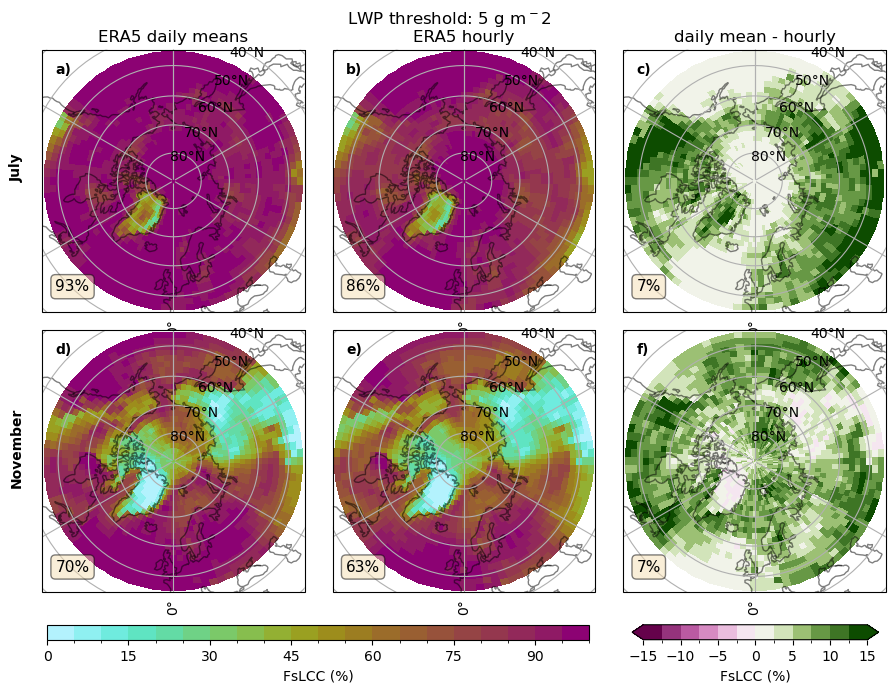

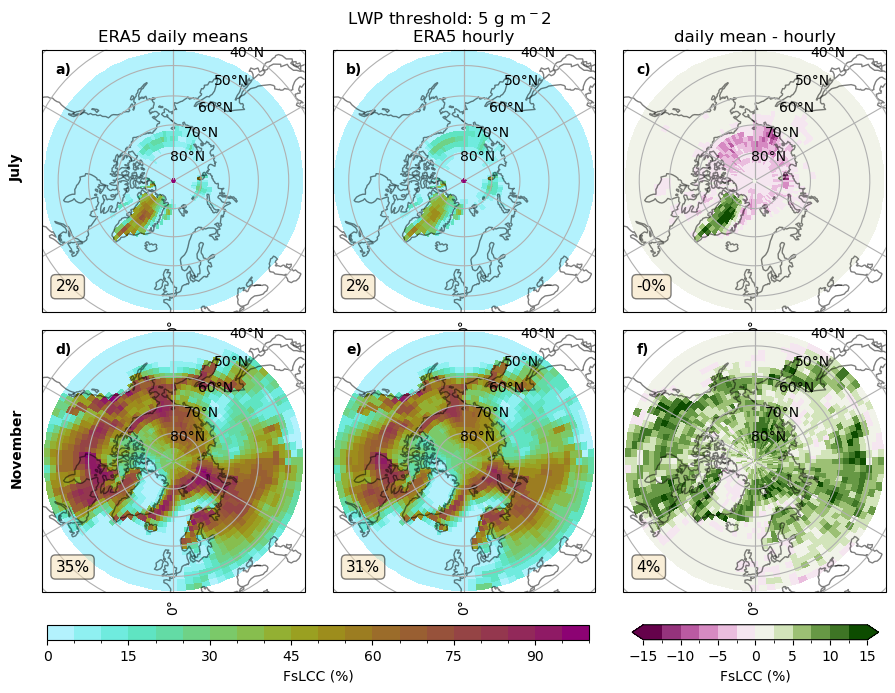

In [50]:
for var_name in ['FLCC', 'FsLCC']:

    val2= ratios['era_500'][var_name + '_month']
    val2_mean= ratios['era_500'][var_name + '' + '_month_cs_mean']

    val3= ratios_hourly['era_500'][var_name + '_month']
    val3_mean = ratios_hourly['era_500'][var_name + '' +'_month_cs_mean']

    diff = val2-val3
    diff_mean = val2_mean-val3_mean

    projection = fct.create_projection(hemisphere)
    density = 4
    f, axsm = plt.subplots(nrows=2,ncols=3, 
                                    subplot_kw={'projection': projection}, 
                                    figsize=[9, 6], sharex=True, sharey=True)
    f.suptitle(f'LWP threshold: {lwp_threshold} g m$^{-2}$', y=1.005)

    model_labels = ['July', 'November', ]

    for ax, row in zip(axsm[:,0], model_labels):
        ax.text(-0.07, 0.55, row, 
                        va='bottom', 
                        ha='center', 
                        rotation='vertical', 
                        rotation_mode='anchor', 
                        transform=ax.transAxes, 
                        fontweight='bold')
    for ax, k in zip(axsm.flatten(), range(len(fct.fig_label))):
        fct.setup_axes(ax, hemisphere, lat_extent)
        ax.text(0.05, 0.95, 
                        f'{fct.fig_label[k]}', 
                        fontweight='bold', 
                        horizontalalignment='left', 
                        verticalalignment='top', 
                        transform=ax.transAxes)
                
    list1 = [val2, val3, diff]
    list_glob = [val2_mean, val3_mean, diff_mean]

    # for ax in axsm.flat:


    for i, (value,hemi_glob,sub_title) in enumerate(zip(list1,list_glob, ["ERA5 daily means", "ERA5 hourly", "daily mean - hourly"] )):
        if i == 0 or i == 1:
            cmap = cm.hawaii_r 
            levels = dict_label[var_name]['levels']
            norm = fct.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
        else:
            cmap=cm.bam
            levels = np.arange(-15,17.5,2.5)
            norm = fct.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
        val = value.sel(lat=slice(45,90)) if hemisphere == 'NH' else value.sel(lat=slice(-90,-45))
        cf = axsm.flat[i].pcolormesh(val.lon, val.lat, (val.where(~np.isnan(val))).sel(month=7), 
                                            transform=ccrs.PlateCarree(), 
                                            cmap=cmap, 
                                            norm=norm)
        axsm.flat[i].set_title(sub_title)
        fct.add_text_box(axsm.flat[i], hemi_glob.sel(hemisphere=hemisphere, month=7), var_name)
        if i == 0:
            cbaxes = f.add_axes([0.0525, -0.045, 0.6025, 0.025])
            plt.colorbar(cf, cax=cbaxes, shrink=0.5, extend=None, orientation="horizontal", label=cb_label)
        elif i == 2:
            cbaxes = f.add_axes([0.7025, -0.045, 0.6025/2.2, 0.025])
            plt.colorbar(cf, cax=cbaxes, shrink=0.5, extend='both', orientation="horizontal", label=cb_label)

    for i, (value,hemi_glob,) in enumerate(zip(list1,list_glob, )):
        if i == 0 or i == 1:
            cmap = cm.hawaii_r 
            levels = dict_label[var_name]['levels']
            norm = fct.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
        else:
            cmap=cm.bam
            levels = np.arange(-15,17.5,2.5)
            norm = fct.BoundaryNorm(levels, ncolors=cmap.N, clip=True)
        val = value.sel(lat=slice(45,90)) if hemisphere == 'NH' else value.sel(lat=slice(-90,-45))
        cf = axsm.flat[i+3].pcolormesh(val.lon, val.lat, (val.where(~np.isnan(val))).sel(month=11), 
                                            transform=ccrs.PlateCarree(), 
                                            cmap=cmap, 
                                            norm=norm)
        fct.add_text_box(axsm.flat[i+3], hemi_glob.sel(hemisphere=hemisphere, month=11), var_name)


                        
    plt.tight_layout(pad=0., w_pad=0., h_pad=0.,)
    figname = f'{var_name}_ERA5_diff_{hemisphere}_2007_2010.png'
    plt.savefig(fig_dir + figname, format='png', bbox_inches='tight', transparent=False)

In [51]:
def plt_time_series_point(lwp_daily,lwp_hourly, tas_daily, tas_hourly, lat, lon, sub_title, t2, lwp_threshold):
  colors = cm.hawaii(range(0, 256, int(256 / 4) + 1))
  # Create a 2x1 subplot figure
  f, axsm = plt.subplots(nrows=2, figsize=[24, 10], sharex=True, sharey=False)
  # f.suptitle(f'LWP threshold: {lwp_threshold} g m$^{-2}$', y=1.005)
  f.suptitle(f'{sub_title} (lat: {lat:.2f}$^o$N, lon: {lon:.2f}$^o$E)', y=1.005)


  # Loop through subplots
  for i, ax in enumerate(axsm.flat):
      ax.grid(True)
      vline_max = 1.25 if i == 0  else 320
      vline_min = 0 if i == 0 else 210
      ax.vlines([lwp_hourly.sel(x=slice((31) * 24)).x[-1] + 0.5,
                lwp_hourly.sel(x=slice((31 + 30) * 24)).x[-1] + 0.5,
                lwp_hourly.sel(x=slice((2 * 31 + 30) * 24)).x[-1] + 0.5,
                lwp_hourly.sel(x=slice((2 * 31 + 2 * 30) * 24)).x[-1] + 0.5,
                lwp_hourly.sel(x=slice((3 * 31 + 2 * 30) * 24)).x[-1] + 0.5,
                lwp_hourly.sel(x=slice((3 * 31 + 3 * 30) * 24)).x[-1] + 0.5,
                lwp_hourly.sel(x=slice((4 * 31 + 3 * 30) * 24)).x[-1] + 0.5,
                lwp_hourly.sel(x=slice((4 * 31 + 4 * 30) * 24)).x[-1] + 0.5], vline_min, vline_max, linestyle='--', color='gray')
      ax.set_xticks(np.arange(12, (4 * 31 + 4 * 30) * 24, 24 * 5))
      ax.set_xticks(np.arange(12, (4 * 31 + 4 * 30) * 24, 24), minor=True)
      ax.set_xlim([lwp_hourly['x'].isel(x=0), len(lwp_hourly['x'])])
      ax.set_ylabel('LWP (kg m-2)' if i == 0 else '2-m Temperature (K)')
      hline_lev = (0.001*lwp_threshold) if i == 0 else 273.15
      ax.hlines(hline_lev, lwp_hourly['x'].isel(x=0), lwp_hourly['x'].isel(x=len(lwp_hourly) - 1), color='k')
      ylim = [1*10**-5,1.2] if i == 0 else [210,320]
      ax.set_ylim(ylim)
      
      for j in range(4):  # Loop through the four years
        # Determine the indices for slicing the data
        start_idx = (j * 31 + j * 30) * 24
        mid_idx = ((j + 1) * 31 + j * 30) * 24
        end_idx = ((j + 1) * 31 + (j + 1) * 30) *24
        
        if j == 0:
            label = ['daily means July', 'hourly July', 'daily means November', 'hourly November']
        else:
            label = [None, None, None, None]
            
        if i == 0:
          # LWP data
          ax.scatter(x=lwp_daily.sel(x=slice(start_idx, mid_idx)).x,
                        y=lwp_daily.sel(x=slice(start_idx, mid_idx)).values,
                        marker='o', color=colors[0], label=label[0])
          ax.plot(lwp_hourly.sel(x=slice(start_idx, mid_idx)).x,
                      lwp_hourly.sel(x=slice(start_idx, mid_idx)).values,
                      color=colors[1], label=label[1])
          ax.scatter(x=lwp_daily.sel(x=slice(mid_idx, end_idx)).x,
                        y=lwp_daily.sel(x=slice(mid_idx, end_idx)).values,
                        marker='o', color=colors[2], label=label[2])
          ax.plot(lwp_hourly.sel(x=slice(mid_idx, end_idx)).x,
                      lwp_hourly.sel(x=slice(mid_idx, end_idx)).values,
                      color=colors[3], label=label[3])
          ax.legend(loc='upper left')
          ax.set_yscale('log')
        elif i == 1:
          # Temperature data
          ax.scatter(x=tas_daily.sel(x=slice(start_idx, mid_idx)).x,
                        y=tas_daily.sel(x=slice(start_idx, mid_idx)).values,
                        marker='o', color=colors[0], )
          ax.plot(tas_hourly.sel(x=slice(start_idx, mid_idx)).x,
                      tas_hourly.sel(x=slice(start_idx, mid_idx)).values,
                      color=colors[1], )
          ax.scatter(x=tas_daily.sel(x=slice(mid_idx, end_idx)).x,
                        y=tas_daily.sel(x=slice(mid_idx, end_idx)).values,
                        marker='o', color=colors[2], )
          ax.plot(tas_hourly.sel(x=slice(mid_idx, end_idx)).x,
                      tas_hourly.sel(x=slice(mid_idx, end_idx)).values,
                      color=colors[3], )
          ax.set_xticklabels(t2[0:len(t2):5].strftime('%Y-%m-%d'), rotation=90)


  plt.tight_layout(pad=0., w_pad=0., h_pad=0.)  ;
  figname = f'lwp_T2m_ERA5_timeseries_{lat:.1f}_{lon:.1f}_2007_2010.png'
  plt.savefig(fig_dir + figname, format='png', bbox_inches='tight', transparent=False)


In [52]:
def time_series_max_min_points(lat, lon, subtitle, ds, ds_hourly, lwp_threshold):
    lwp_nh_point = ds['orig']['era_500']['lwp'].sel(lat=lat, lon=lon, method='nearest').squeeze()
    tas_nh_point = ds['orig']['era_500']['tas'].sel(lat=lat, lon=lon, method='nearest').squeeze()
    lwp_nh_hourly = ds_hourly['orig']['era_500']['lwp'].sel(lat=lat, lon=lon, method='nearest').squeeze()
    tas_nh_hourly = ds_hourly['orig']['era_500']['tas'].sel(lat=lat, lon=lon, method='nearest').squeeze()
    # Define time ranges
    time_ranges = [
        ("2007-07", 31), ("2007-11", 30),
        ("2008-07", 31), ("2008-11", 30),
        ("2009-07", 31), ("2009-11", 30),
        ("2010-07", 31), ("2010-11", 30)
    ]

    # Initialize empty arrays
    t2 = []
    _lwp = []
    _lwp_hourly = []
    _tas = []
    _tas_hourly = []

    t2 = xr.cftime_range(start="2007-07", periods=31, freq="D").to_datetimeindex()
    t2 = t2.append(xr.cftime_range(start="2007-11", periods=30, freq="D").to_datetimeindex())
    t2 = t2.append(xr.cftime_range(start="2008-07", periods=31, freq="D").to_datetimeindex())
    t2 = t2.append(xr.cftime_range(start="2008-11", periods=30, freq="D").to_datetimeindex())
    t2 = t2.append(xr.cftime_range(start="2009-07", periods=31, freq="D").to_datetimeindex())
    t2 = t2.append(xr.cftime_range(start="2009-11", periods=30, freq="D").to_datetimeindex())
    t2 = t2.append(xr.cftime_range(start="2010-07", periods=31, freq="D").to_datetimeindex())
    t2 = t2.append(xr.cftime_range(start="2010-11", periods=30, freq="D").to_datetimeindex())
    t2



    # Loop through time ranges and concatenate data
    for start, periods in time_ranges:
        _lwp.append(lwp_nh_point.sel(time=slice(start, start)).values)
        _lwp_hourly.append(lwp_nh_hourly.sel(time=slice(start, start)).values)
        
        _tas.append(tas_nh_point.sel(time=slice(start, start)).values)
        _tas_hourly.append(tas_nh_hourly.sel(time=slice(start, start)).values)

    # Concatenate the lists
    # t2 = np.concatenate(t2)
    _lwp = np.concatenate(_lwp)
    _lwp_hourly = np.concatenate(_lwp_hourly)
    _tas = np.concatenate(_tas)
    _tas_hourly = np.concatenate(_tas_hourly)

    # Create DataArrays
    lwp_daily = xr.DataArray(data=_lwp, coords={'x': np.arange(12, len(_lwp_hourly), 24)})
    lwp_hourly = xr.DataArray(data=_lwp_hourly, coords={'x': np.arange(len(_lwp_hourly))})

    tas_daily = xr.DataArray(data=_tas, coords={'x': np.arange(12, len(_tas_hourly), 24)})
    tas_hourly = xr.DataArray(data=_tas_hourly, coords={'x' : np.arange(len(_tas_hourly))})

    # 

    lat = lwp_nh_hourly.lat.round(2).values
    lon = lwp_nh_hourly.lon.round(2).values
    plt_time_series_point(lwp_daily,lwp_hourly, tas_daily, tas_hourly, lat, lon, subtitle, t2, lwp_threshold)

In [53]:
_idx7_min = diff.sel(month=7).argmin(dim=("lat", 'lon'), skipna=True)
lat7_min = diff.sel(month=7)[_idx7_min].lat.values
lon7_min = diff.sel(month=7)[_idx7_min].lon.values
# diff.sel(month=7)[_idx7_min].month.values
_idx7_max = diff.sel(month=7).argmax(dim=("lat", 'lon'), skipna=True)
lat7_max = diff.sel(month=7)[_idx7_max].lat.values
lon7_max = diff.sel(month=7)[_idx7_max].lon.values

In [54]:
_idx11_min = diff.sel(month=11).argmin(dim=("lat", 'lon'), skipna=True)
lat11_min = diff.sel(month=11)[_idx11_min].lat.values
lon11_min = diff.sel(month=11)[_idx11_min].lon.values
_idx11_max = diff.sel(month=11).argmax(dim=("lat", 'lon'), skipna=True)
lat11_max = diff.sel(month=11)[_idx11_max].lat.values
lon11_max = diff.sel(month=11)[_idx11_max].lon.values

In [55]:
lats_lons = [[lat7_min, lon7_min, 'Min difference in July mean'],
 [lat7_max, lon7_max, 'Max difference in July mean'],
 [lat11_min, lon11_min, 'Min difference in November mean'],
 [lat11_max, lon11_max, 'Max difference in November mean']]

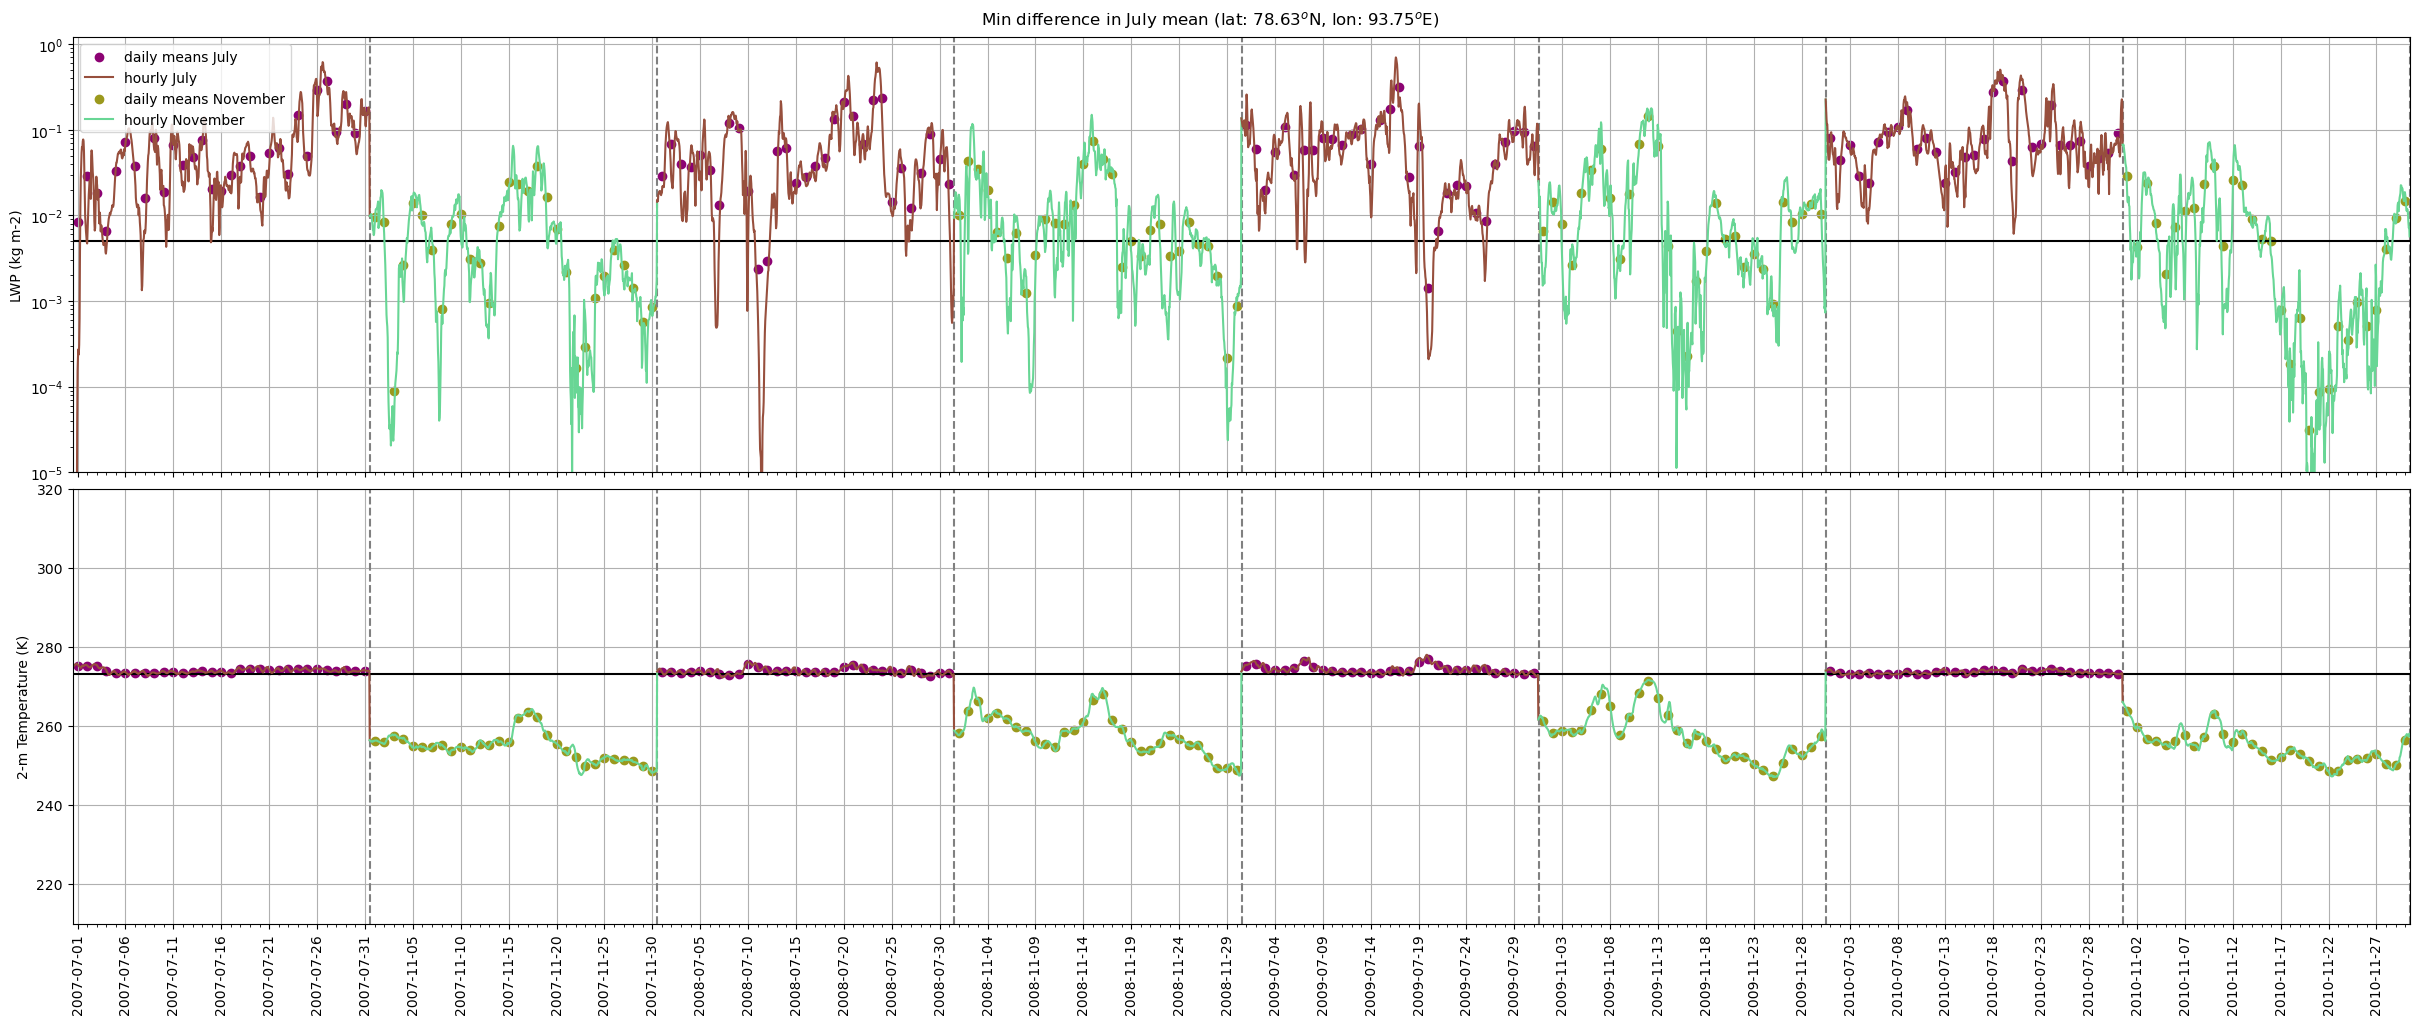

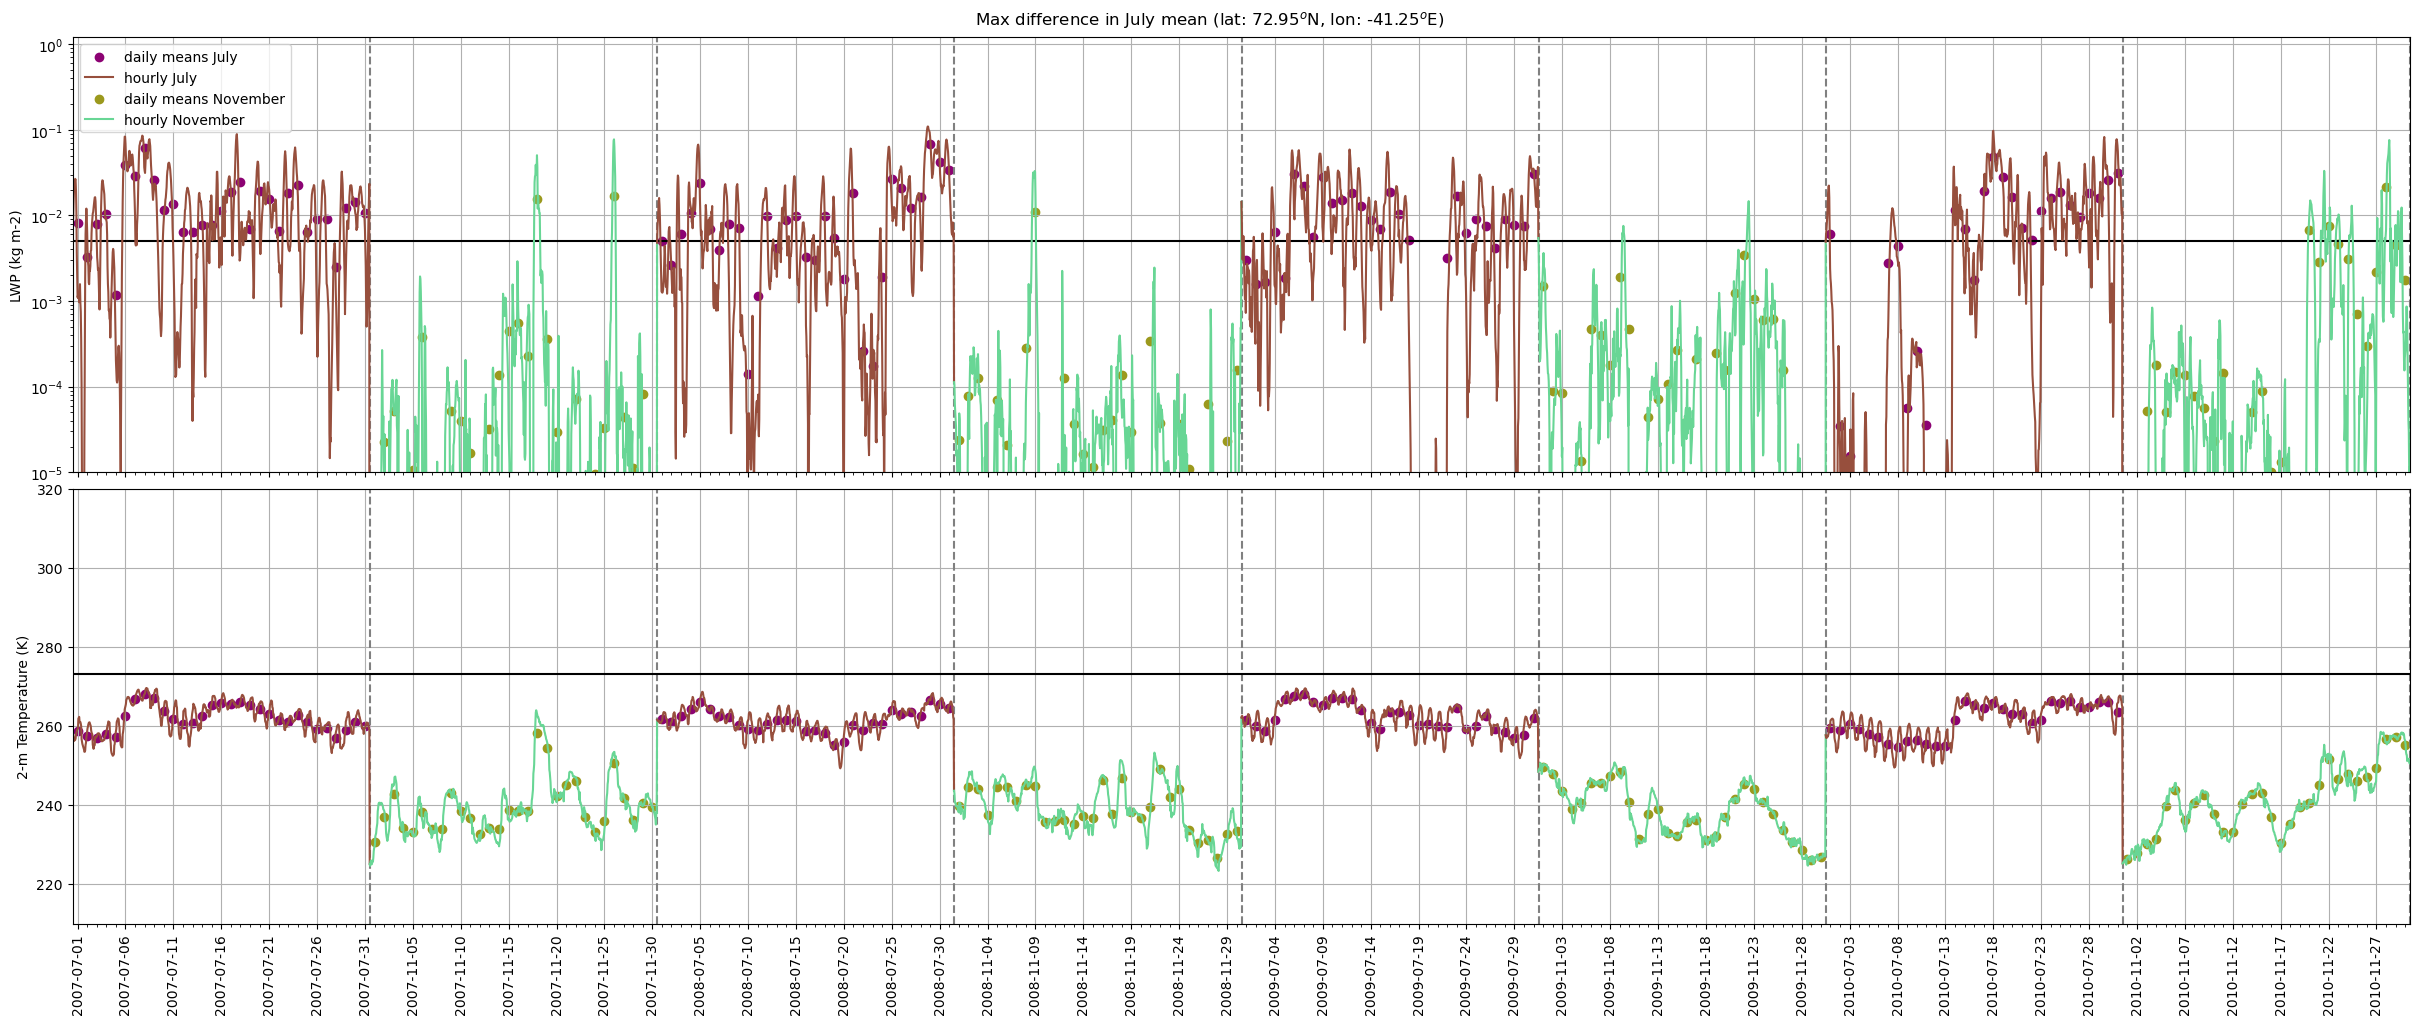

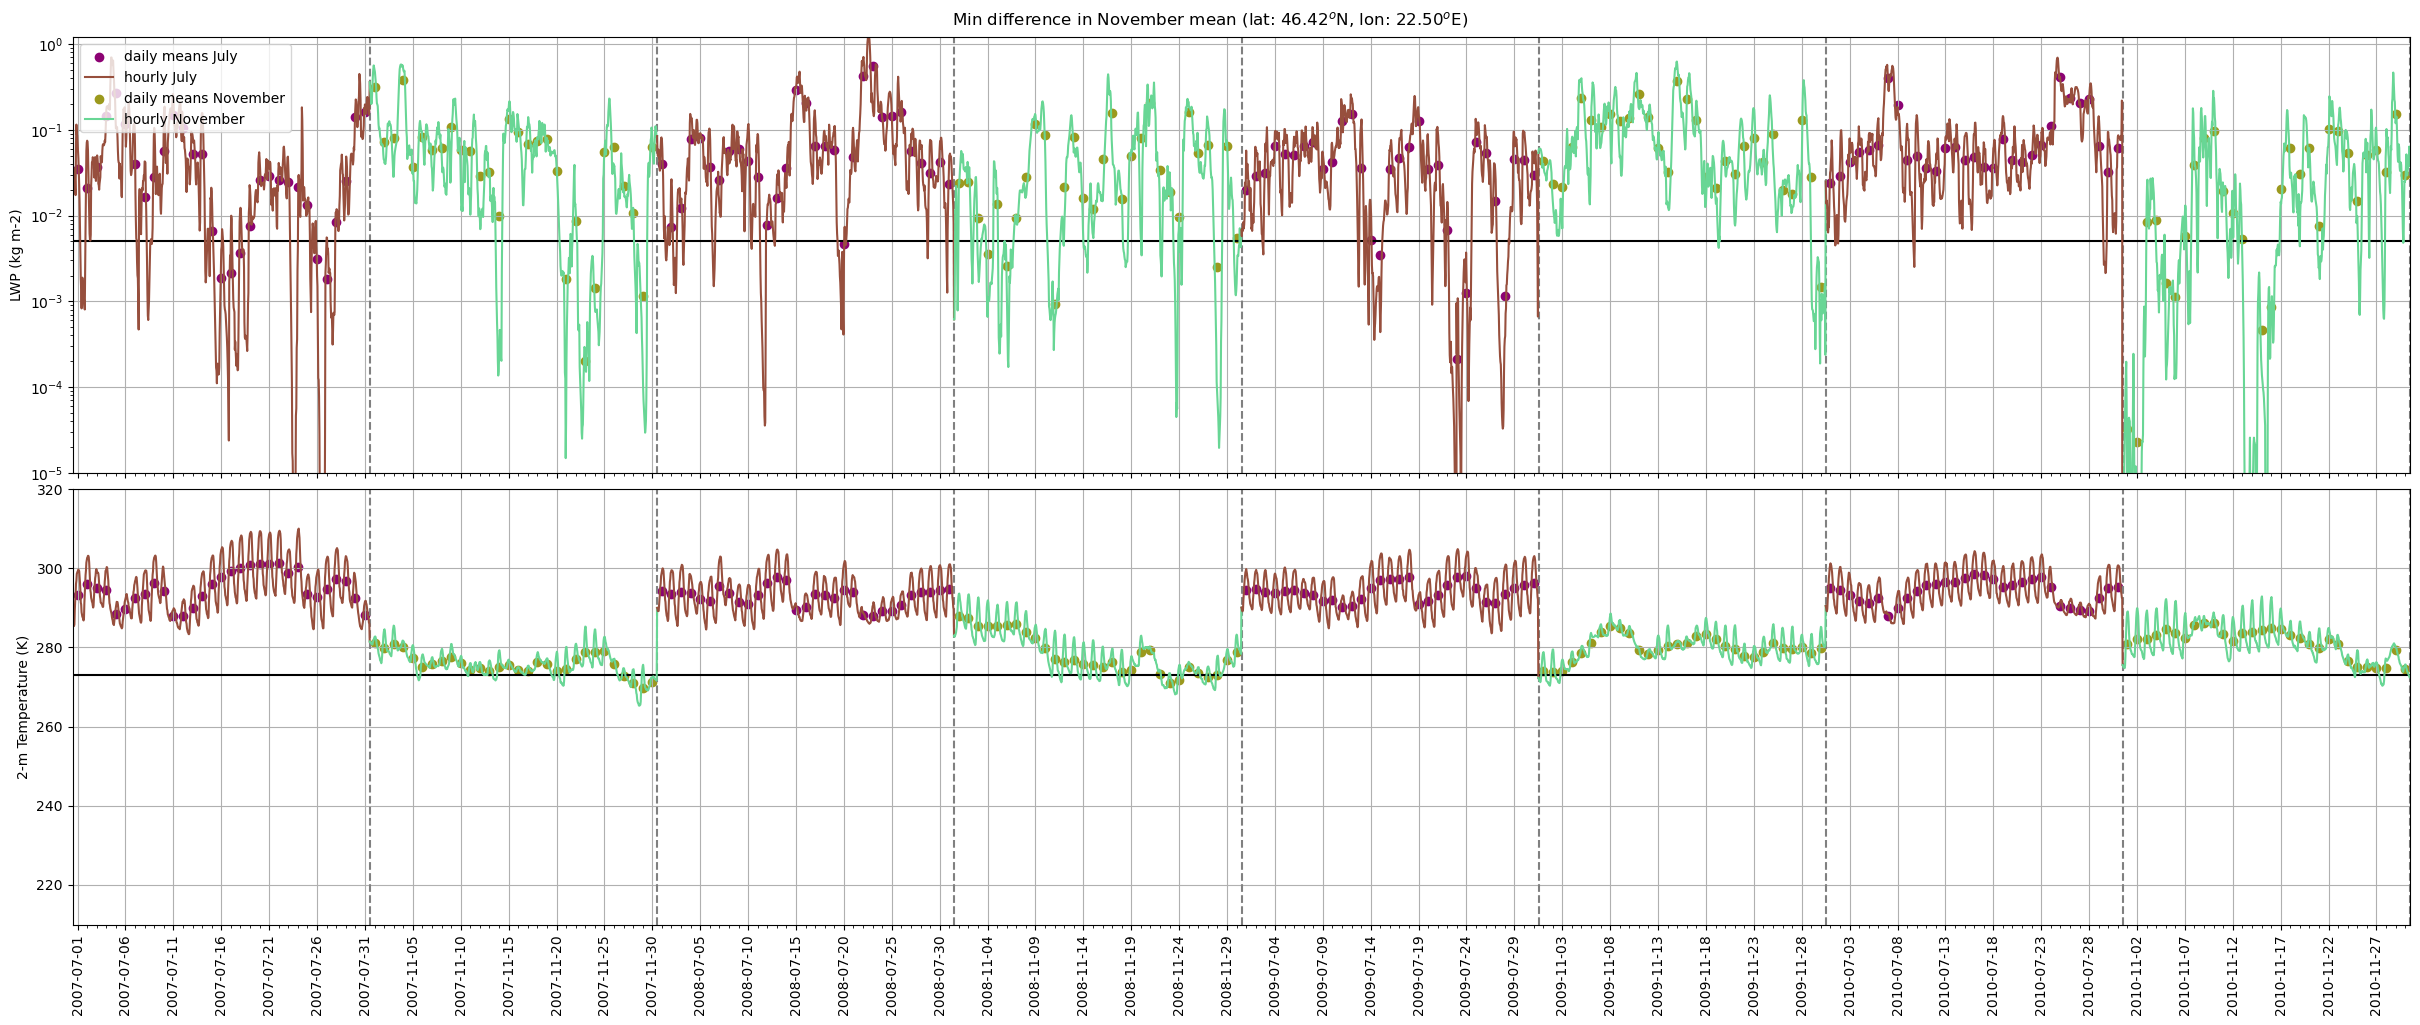

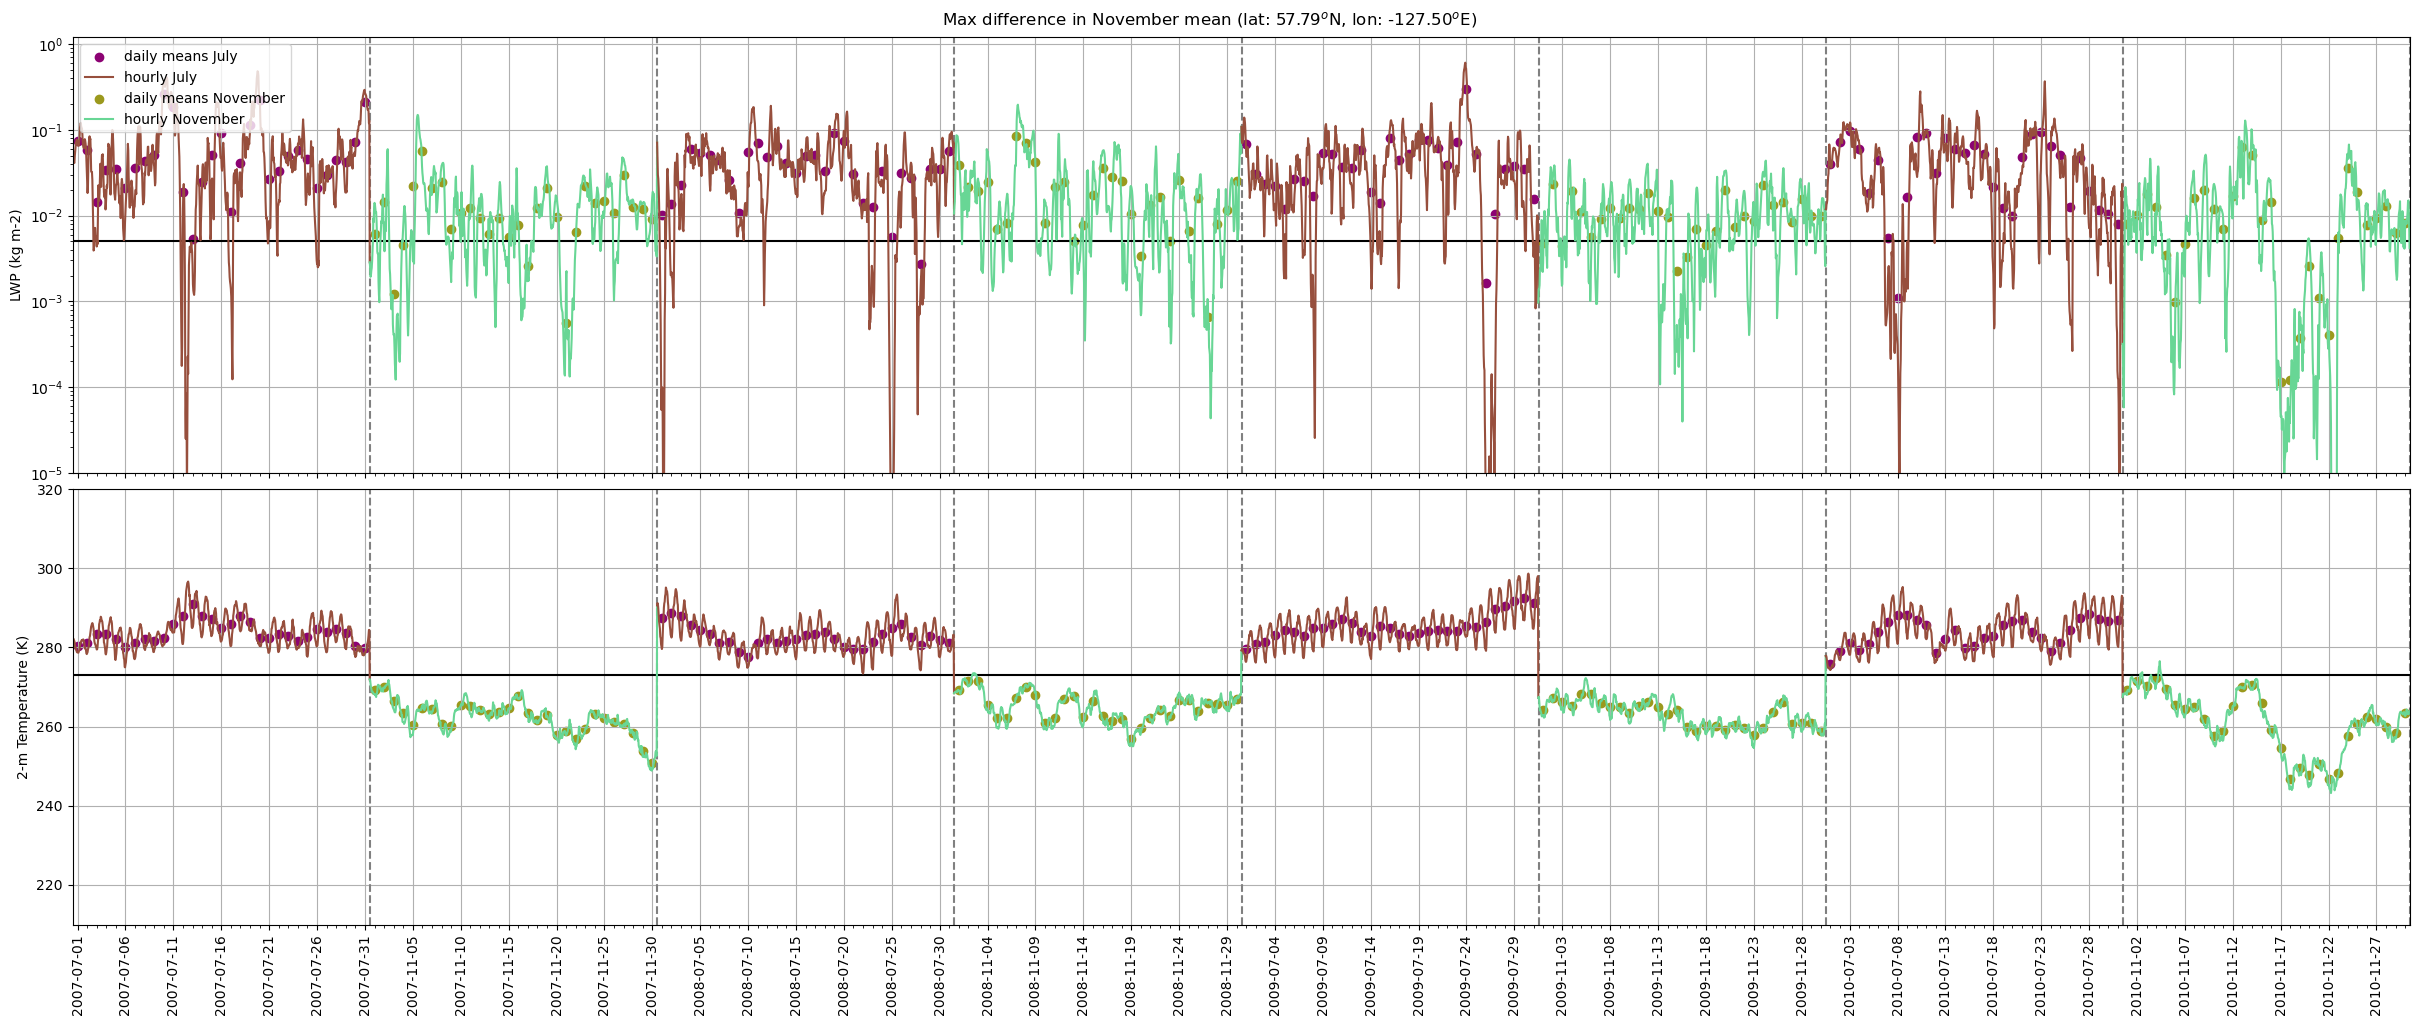

In [56]:
for lat, lon, subtitle in lats_lons:
    time_series_max_min_points(lat, lon, subtitle, ds, ds_hourly, lwp_threshold)
    